Test radial velocity calculation of the Mizar system
=====================================================


This is an attempt to validate [Enrico Gerlachs][1]s radial velocity paper
while also learning some IPython.

In his paper Enrico Gerlach explaines the computation of a double stars radial velocity from orbital parameters using the example of [Mizar A][2] ($\zeta$UMa).

[IPython][3] is an interactive Python shell that allows a cell-oriented workflow you might know in Maple, Mathematica or Maxima.

[1] Enrico Gerlach, Himmelmechanische Beschreibung der Orientierung von Doppelsternsystemen
[2] https://en.wikipedia.org/wiki/Mizar_and_Alcor
[3] http://ipython.org/

First we tell IPython to use inline plots.

In [23]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=11, usetex=False)



Now we add some python imports.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from astropy.time import Time

### The Orbital parameters of the MizarAa and Ab.
$\Omega$ is not used as we are only interested in the $\delta z$ component of the system.

In [25]:
H_alpha = 6562.8 * u.AA

m1 = 2.43 * u.solMass
m2 = 2.50 * u.solMass
M = m1 + m2
e = 0.5354
omega1 = 104.3 * u.degree
omega2 = omega1 + 180.0 * u.degree
Omega = 106.0 *  u.degree # unused
i = 60.5 * u.degree
P = 20.53835 * u.day
T0 = Time(2447636.07, format='jd')
V0 = -6.31 * u.km / u.s

Let's derive a1 and a2 from
$$a = a_1 + a_2$$
$$a_1 M_1 = a_2 M_2$$ and
$$M * P^2 = a^3$$
Note that the last formula is relative to our solar system, so M needs to be in solar masses, P in years and a in astronomical units.


In [26]:
# From Enricos paper
# a1 = 0.127 * u.AU
# a2 = 0.123 * u.AU

a = np.power(M.to(u.solMass).value * (P.to(u.year)**2).value, 1./3.) * u.AU
a1=(a*m2)/(M)
a2 = a - a1

a1 = a1.to(u.AU)
a2 = a2.to(u.AU)

print("We get %s and %s" % (a1, a2))

We get 0.126675398669521 AU and 0.12312848750677435 AU


Deriving K1 and K2 accordinfg to the paper yields:

In [29]:
# From Enricos paper
# a1 = 66.98 * u.km / u.s
# a2 = 68.91 * u.km / u.s

K = (2.0 * np.pi / P) * a * np.sin(i) / np.sqrt(1.0 - e*e)

K1 = m2 / M * K
K2 = m1 / M * K

print("We get %s and %s" % (K1.to(u.km / u.s), K2.to(u.km / u.s)))

We get 69.14561952803487 km / s and 67.20954218124989 km / s


The radial velocities $V$ is function of $K$, $\omega$ and the true anomaly $f$.

In [30]:
def V(K, f, omega):
    return -K*(np.cos(f+omega) + e*np.cos(omega))

### The true, mean and eccentric anomalies of the Kepler orbit

The true anomaly $f$ used in the calculation above can be derived from the eccentric anomaly $E$.

$E$ must be computed iteratively from the mean anomaly $M$ as we cannot invert the Kepler equation $$M = E + e * sin(E)$$

Finally $M$ is a linear function of time, the epoche $T0$ and the orbital period $P$.

Have a look at Wikipedia: <https://en.wikipedia.org/wiki/True_anomaly>

In [31]:
def true_anomaly(eccentric_anomaly, e):
    y = np.sqrt(1+e) * np.sin(eccentric_anomaly/2)
    x = np.sqrt(1-e) * np.cos(eccentric_anomaly/2)
    return 2 * np.arctan2(y, x)

def eccentric_anomaly(mean_anomaly, e):
    
    def inverse(M):
        eps = 1e-7
        E = 0
        for i in range(1, 100):
            dE = M + e * np.sin(E) - E
            # This is the Kepler version.
            # Newton is not used because of convergence issues arround pi
            # due to modulo 2pi effects
            # dE = (M + e * np.sin(E) - E) / (1 - e * np.cos(E))
            E += dE
            if -eps < dE < +eps:
                return E

        raise ValueError("true_anomaly calculation did not converge for M=%s and e=%s" % (M, e))
    
    if isinstance(mean_anomaly, u.Quantity):
        mean_anomaly = mean_anomaly.to(u.radian).value
    
    if isinstance(mean_anomaly, np.ndarray):
        return np.array([inverse(mi) for mi in mean_anomaly]) * u.radian
    else:
        return inverse(mean_anomaly) * u.radian

def mean_anomaly(t, T0, P):
    return 2 * np.pi * u.radian * (t - T0) / P

#### Lets visualize all above in the period ofter the epoche.

In [32]:
# The following line should be fixed in numpy 1.10 -- says astropy ;-)
# t = np.linspace(T0, T0 + P, 200)
t = Time(np.linspace(T0.jd, (T0 + P).jd, 200), format='jd')

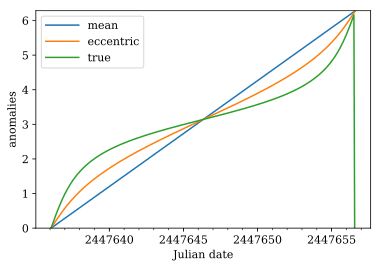

In [33]:
M = mean_anomaly(t, T0, P)
E = eccentric_anomaly(M, e)
f = true_anomaly(E, e)

ax = plt.axes()
ax.plot(t.jd, M, label='mean')
ax.plot(t.jd, E, label='eccentric')
ax.plot(t.jd, f, label='true')

# ax.set_title('The anomalies look like this')
ax.set_ylabel('anomalies')
ax.set_xlabel('Julian date')
ax.set_ylim(0, 2*np.pi)

ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
ax.legend()
plt.show()

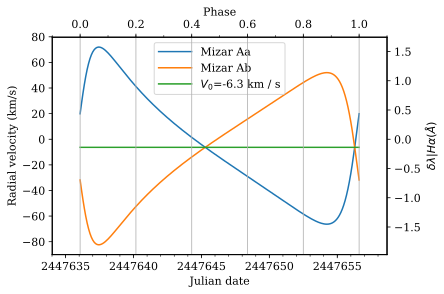

In [34]:
#It follows an example to display two axis in the same plot

plot = plt.axes()

# we need additional x and y axes
addx = plot.twiny()
addy = plot.twinx()

V1 = (V(K1, f, omega1) + V0).to('km/s')
plot.plot(t.jd, V1, label='Mizar Aa')

V2 = (V(K2, f, omega2) + V0).to('km/s')
plot.plot(t.jd, V2, label='Mizar Ab')
plot.plot(t.jd, np.ones(t.size)*V0,
            label=r'$V_0$=%.1f %s'%(V0.value, V0.unit))

# assure both x-scales match
plot.set_xlim((T0-0.1*P).jd, (T0+1.1*P).jd)
addx.set_xlim(-0.1, 1.1)

# convert radial velocity to red-shift at H_alpha
vmin, vmax = plot.get_ylim() * u.km / u.s
lmin = (vmin / const.c).to(1) * H_alpha
lmax = (vmax / const.c).to(1) * H_alpha

# plot.xaxis.set_major_locator(plt.MaxNLocator(5))
# plot.xaxis.set_major_locator(plt.MultipleLocator(10))
plot.xaxis.set_minor_locator(plt.MultipleLocator(1))
plot.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))

addx.xaxis.set_minor_locator(plt.MultipleLocator(0.1))

addy.set_ylim(lmin.value, lmax.value)

plot.set_ylabel('Radial velocity (km/s)')
plot.set_xlabel('Julian date')
addx.set_xlabel('Phase')
addy.set_ylabel(r'$\delta\lambda \| H\alpha (\AA)$')
addx.grid(True)
plot.legend()
plt.show()